<a href="https://colab.research.google.com/github/mertgokcer/Yapay_sinir_aglari/blob/main/yapay_sinir_aglari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np


dataset_path = "/content/drive/MyDrive/Yükseklisans/Yapay_Sinir_Aglari/data"

In [ ]:
# 🔹 1. Adım: Tüm veri setini yükleme
full_dataset = image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=32,
    seed=123
)

# 📌 Sınıf isimlerini al
class_names = full_dataset.class_names
print("Sınıflar:", class_names)

# 🔹 2. Adım: %80 eğitim + %20 test olarak bölme
total_size = len(full_dataset)
test_size = int(total_size * 0.2)
train_val_size = total_size - test_size

train_val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

val_dataset = image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

test_dataset = image_dataset_from_directory(
    dataset_path,
    seed=123,
    image_size=(224, 224),
    batch_size=32
)
test_dataset = test_dataset.skip(train_val_size)  # Eğitim+validasyon sonrası kalan veriyi test olarak al

# 🔹 3. Adım: Eğitim setini %80 eğitim - %20 doğrulama olarak bölme
train_batches = int(len(train_val_dataset) * 0.8)
train_dataset = train_val_dataset.take(train_batches)  # %80 eğitim
val_dataset = train_val_dataset.skip(train_batches)  # %20 validasyon

print(f"Eğitim seti boyutu: {len(train_dataset)} batch")
print(f"Doğrulama seti boyutu: {len(val_dataset)} batch")
print(f"Test seti boyutu: {len(test_dataset)} batch")

# 📌 4. Adım: Veri Arttırımı (Data Augmentation)
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.2),
    keras.layers.RandomZoom(0.2)
])

# 📌 Model Seçimi (DenseNet121)
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Modeli donduralım (Fine-tuning için bu satır kaldırılabilir)
base_model.trainable = False

# 📌 Model Katmanlarını Tanımlama
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Veri arttırımı
x = tf.keras.layers.Rescaling(1./255)(x)  # Normalizasyon
x = base_model(x, training=False)  # Pre-trained model
x = GlobalAveragePooling2D()(x)  # Global average pooling
x = Dense(256, activation="relu")(x)  # 1. Dense katmanı
x = Dropout(0.5)(x)  # Dropout katmanı
x = Dense(128, activation="relu")(x)  # 2. Dense katmanı
output_layer = Dense(len(class_names), activation="softmax")(x)  # Çıkış katmanı

# 📌 Modeli oluştur
model = Model(inputs, output_layer)

# 📌 5. Adım: Callback'leri Tanımlama (Ağırlıkları kaydetmek için ModelCheckpoint eklendi)
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor="val_loss", save_best_only=True, mode="min")

early_stopping = EarlyStopping(monitor="val_loss", patience=25, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-6)

# 📌 6. Adım: ADAM Optimizasyonu Tanımlama
optimizer = keras.optimizers.Adam(learning_rate=0.001)

# 📌 Modeli derleme
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 📌 Model özeti
model.summary()

# 📌 7. Adım: Modeli eğitme ve en iyi ağırlıkları kaydetme
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=100,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# 📌 8. Adım: En iyi ağırlıkları yükleme
model.load_weights(checkpoint_path)

# 📌 9. Adım: Modeli Test Seti Üzerinde Değerlendirme
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test doğruluğu: {test_acc:.4f}")

# 📌 10. Adım: Test seti üzerinde tahmin (inference) yapma ve görselleştirme
def predict_and_visualize(model, dataset, class_names, num_samples=5):
    plt.figure(figsize=(10, 5))

    for images, labels in dataset.take(1):  # İlk batch'i al
        preds = model.predict(images)  # Model tahminleri
        pred_labels = np.argmax(preds, axis=1)  # En yüksek olasılığı alan sınıf

        for i in range(num_samples):
            plt.subplot(1, num_samples, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.axis("off")
            true_label = class_names[labels[i].numpy()]
            pred_label = class_names[pred_labels[i]]
            plt.title(f"Gerçek: {true_label}\nTahmin: {pred_label}", fontsize=10)

    plt.show()

# 📌 Test verisi üzerinde tahmin yap ve görselleştir
predict_and_visualize(model, test_dataset, class_names, num_samples=5)

Found 7553 files belonging to 2 classes.
Sınıflar: ['with_mask', 'without_mask']
Found 7553 files belonging to 2 classes.
Using 6043 files for training.
Found 7553 files belonging to 2 classes.
Using 1510 files for validation.
Found 7553 files belonging to 2 classes.
Eğitim seti boyutu: 151 batch
Doğrulama seti boyutu: 38 batch
Test seti boyutu: 47 batch
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,333,058 (27.97 MB)

 Trainable params: 295,554 (1.13 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

Epoch 1/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8403 - loss: 0.3538

151/151 ━━━━━━━━━━━━━━━━━━━━ 1289s 8s/step - accuracy: 0.8407 - loss: 0.3531 - val_accuracy: 0.9926 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 2/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9348 - loss: 0.1543

151/151 ━━━━━━━━━━━━━━━━━━━━ 1166s 8s/step - accuracy: 0.9348 - loss: 0.1543 - val_accuracy: 0.9901 - val_loss: 0.0287 - learning_rate: 0.0010
Epoch 3/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9491 - loss: 0.1276

151/151 ━━━━━━━━━━━━━━━━━━━━ 1152s 8s/step - accuracy: 0.9492 - loss: 0.1276 - val_accuracy: 0.9917 - val_loss: 0.0255 - learning_rate: 0.0010
Epoch 4/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9633 - loss: 0.1050

151/151 ━━━━━━━━━━━━━━━━━━━━ 1160s 8s/step - accuracy: 0.9632 - loss: 0.1051 - val_accuracy: 0.9934 - val_loss: 0.0248 - learning_rate: 0.0010
Epoch 5/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1147s 8s/step - accuracy: 0.9618 - loss: 0.0979 - val_accuracy: 0.9942 - val_loss: 0.0291 - learning_rate: 0.0010
Epoch 6/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1166s 8s/step - accuracy: 0.9680 - loss: 0.0822 - val_accuracy: 0.9934 - val_loss: 0.0266 - learning_rate: 0.0010
Epoch 7/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1144s 8s/step - accuracy: 0.9636 - loss: 0.0936 - val_accuracy: 0.9934 - val_loss: 0.0260 - learning_rate: 0.0010
Epoch 8/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1146s 8s/step - accuracy: 0.9704 - loss: 0.0792 - val_accuracy: 0.9926 - val_loss: 0.0312 - learning_rate: 0.0010
Epoch 9/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1154s 8s/step - accuracy: 0.9656 - loss: 0.0920 - val_accuracy: 0.9934 - val_loss: 0.0254 - learning_rate: 0.0010
Epoch 10/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1177s 8s/step - accuracy: 0.9672 - loss:

151/151 ━━━━━━━━━━━━━━━━━━━━ 1157s 8s/step - accuracy: 0.9768 - loss: 0.0651 - val_accuracy: 0.9942 - val_loss: 0.0241 - learning_rate: 1.0000e-05
Epoch 18/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1183s 8s/step - accuracy: 0.9783 - loss: 0.0574 - val_accuracy: 0.9934 - val_loss: 0.0249 - learning_rate: 1.0000e-05
Epoch 19/100
151/151 ━━━━━━━━━━━━━━━━━━━━ 1149s 8s/step - accuracy: 0.9761 - loss: 0.0577 - val_accuracy: 0.9926 - val_loss: 0.0262 - learning_rate: 1.0000e-05
Epoch 20/100
 12/151 ━━━━━━━━━━━━━━━━━━━━ 14:28 6s/step - accuracy: 0.9779 - loss: 0.0520

KeyboardInterrupt: 

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7

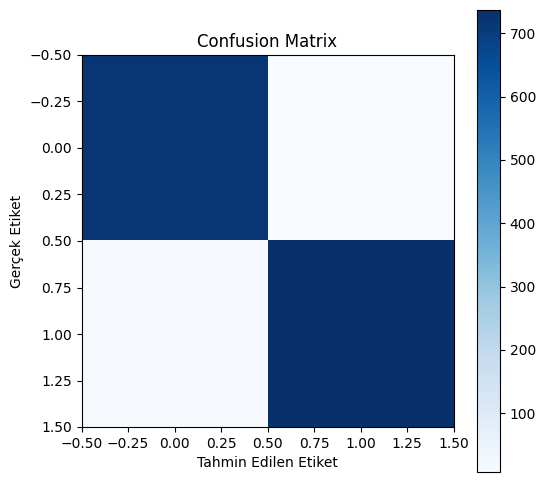

✅ Accuracy (Doğruluk): 0.9885
✅ Precision (Kesinlik): 0.9885
✅ Recall (Hassasiyet): 0.9885
✅ Specificity (Özgüllük): 0.9904
✅ F1-score: 0.9885


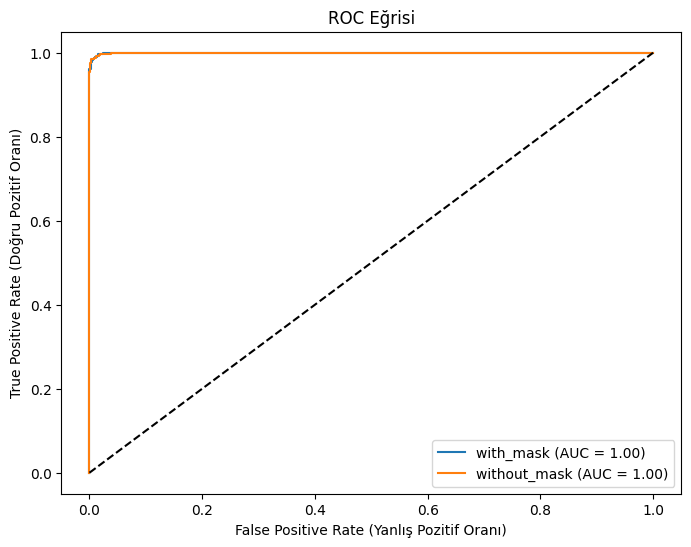

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# 📌 1. Adım: Test veri seti üzerinde tahmin yapma
y_true = []
y_pred = []
y_scores = []

for images, labels in test_dataset:
    preds = model.predict(images)  # Model tahminleri (olasılıklar)
    pred_labels = np.argmax(preds, axis=1)  # En yüksek olasılıklı sınıfı al
    y_true.extend(labels.numpy())  # Gerçek etiketleri ekle
    y_pred.extend(pred_labels)  # Tahmin edilen etiketleri ekle
    y_scores.extend(preds)  # Tüm olasılıkları kaydet

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)  # Her sınıf için olasılıkları içerir

# 📌 2. Adım: Confusion Matrix Hesaplama ve Görselleştirme
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.xlabel("Tahmin Edilen Etiket")
plt.ylabel("Gerçek Etiket")
plt.title("Confusion Matrix")
plt.show()

# 📌 3. Adım: Metrikleri Hesaplama
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

# Specificity Hesaplama
tn = conf_matrix[0, 0]  # True Negative
fp = conf_matrix[0, 1]  # False Positive
specificity = tn / (tn + fp) if (tn + fp) != 0 else 0  # Özgüllük formülü

# 📌 4. Adım: Sonuçları Yazdırma
print(f"✅ Accuracy (Doğruluk): {accuracy:.4f}")
print(f"✅ Precision (Kesinlik): {precision:.4f}")
print(f"✅ Recall (Hassasiyet): {recall:.4f}")
print(f"✅ Specificity (Özgüllük): {specificity:.4f}")
print(f"✅ F1-score: {f1:.4f}")

# 📌 5. Adım: ROC Eğrisi ve AUC Skoru
plt.figure(figsize=(8, 6))
for i in range(len(class_names)):  # Her sınıf için ROC eğrisi çizelim
    fpr, tpr, _ = roc_curve(y_true == i, y_scores[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], "k--")  # Rastgele tahmin çizgisi
plt.xlabel("False Positive Rate (Yanlış Pozitif Oranı)")
plt.ylabel("True Positive Rate (Doğru Pozitif Oranı)")
plt.title("ROC Eğrisi")
plt.legend(loc="lower right")
plt.show()

Model	                   Accuracy	Precision	Recall	F1-Score

MLP (Multilayer Perceptron)	0.92	0.91	    0.90	0.90

RBF (Radial Basis Function)	0.88	0.87	    0.85	0.86